Question8_GrabCut_Segmentation

In [1]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
input_image_path = "../data/a1images/daisy.jpg"  
output_dir = "../data/output_images"  
output_mask = f"{output_dir}/q8_segmentation_mask.png"
output_fg = f"{output_dir}/q8_foreground.png"
output_bg = f"{output_dir}/q8_background.png"
output_enhanced = f"{output_dir}/q8_enhanced_image.png"
output_comparison = f"{output_dir}/q8_original_vs_enhanced.png"

os.makedirs(output_dir, exist_ok=True)

In [3]:
# Load the image and apply GrabCut segmentation
bgr = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(input_image_path)

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
h, w = rgb.shape[:2]

# Initial rectangle (keep margins so the flower falls inside)
rect_margin = 0.10
rect = (int(w * rect_margin), int(h * rect_margin),
        int(w * (1 - 2 * rect_margin)), int(h * (1 - 2 * rect_margin)))

# Initialize GrabCut mask
mask = np.zeros((h, w), np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
cv2.grabCut(bgr, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Create binary mask (foreground=1, background=0)
hard_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)

# Clean-up mask (remove small specks/fill tiny gaps)
kernel = np.ones((3, 3), np.uint8)
hard_mask = cv2.morphologyEx(hard_mask, cv2.MORPH_OPEN, kernel, iterations=1)
hard_mask = cv2.morphologyEx(hard_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# Separate foreground and background using the mask
fg = (rgb * hard_mask[..., None]).astype(np.uint8)
bg = (rgb * (1 - hard_mask[..., None])).astype(np.uint8)

In [4]:
# Apply Gaussian blur to background and blend
# Apply strong blur to the background
blur_sigma = 12.0
blurred_bg = cv2.GaussianBlur(rgb, (0, 0), sigmaX=blur_sigma, sigmaY=blur_sigma)

# Feather the binary mask to create a soft alpha mask
soft_mask = cv2.GaussianBlur((hard_mask * 255).astype(np.uint8), (0, 0), sigmaX=3, sigmaY=3)
alpha = (soft_mask.astype(np.float32) / 255.0)[..., None]  # Convert to float and add dimension

# Blend foreground (sharp) with blurred background
enhanced_image = np.clip(alpha * rgb + (1 - alpha) * blurred_bg, 0, 255).astype(np.uint8)

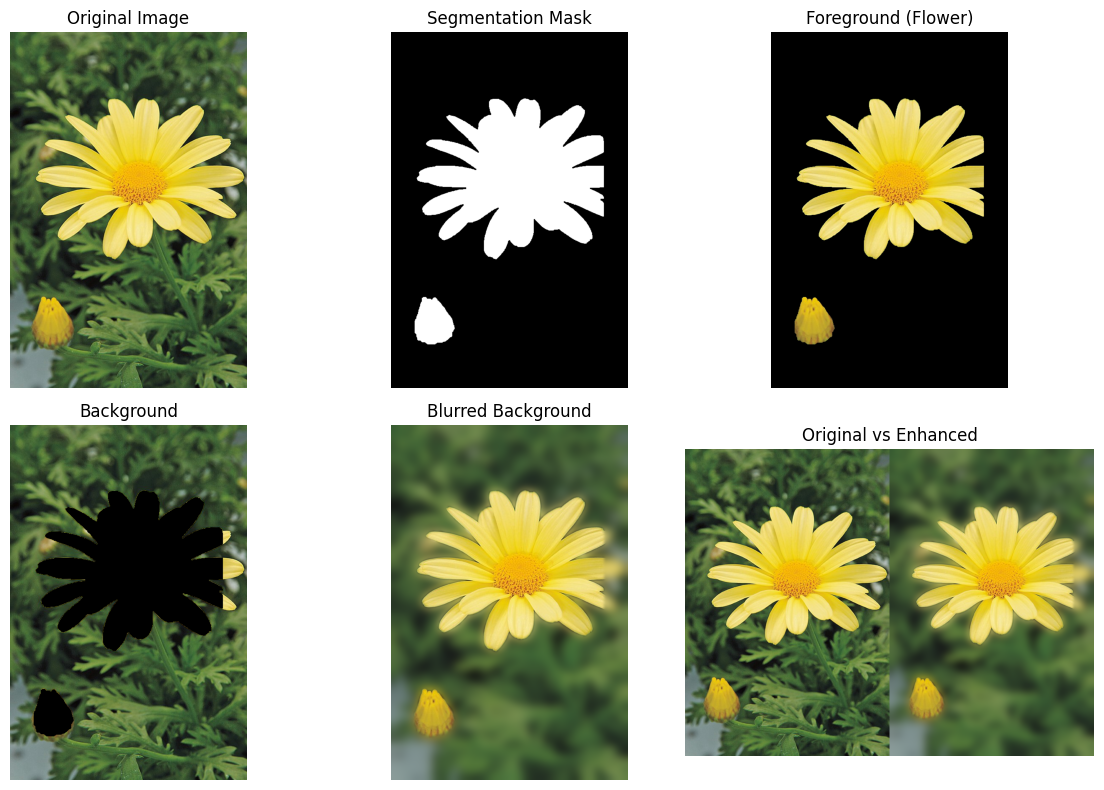

In [5]:
# Display the results
plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.title("Original Image");          plt.imshow(rgb); plt.axis("off")
plt.subplot(2,3,2); plt.title("Segmentation Mask");       plt.imshow(hard_mask * 255, cmap="gray"); plt.axis("off")
plt.subplot(2,3,3); plt.title("Foreground (Flower)");    plt.imshow(fg); plt.axis("off")
plt.subplot(2,3,4); plt.title("Background");             plt.imshow(bg); plt.axis("off")
plt.subplot(2,3,5); plt.title("Blurred Background");     plt.imshow(enhanced_image); plt.axis("off")
plt.subplot(2,3,6); plt.title("Original vs Enhanced");   plt.imshow(np.hstack([rgb, enhanced_image])); plt.axis("off")
plt.tight_layout()

In [6]:
# Save output images
cv2.imwrite(output_mask, hard_mask * 255)
cv2.imwrite(output_fg, fg)
cv2.imwrite(output_bg, bg)
cv2.imwrite(output_enhanced, cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2BGR))
cv2.imwrite(output_comparison, cv2.cvtColor(np.hstack([rgb, enhanced_image]), cv2.COLOR_RGB2BGR))

plt.show()

print("Done. Results saved to:", output_dir)

Done. Results saved to: ../data/output_images
